In [1]:
## imports
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ClassificationReport


# get data
startup = pd.read_csv("investments_VC.csv")

#checking null value
startup.isnull().sum(axis = 0)


permalink                   0
name                        1
homepage_url             3449
category_list            3961
 market                  3968
 funding_total_usd          0
country_code             5273
state_code              19277
region                   5273
city                     6116
funding_rounds              0
founded_at              10884
founded_month           10956
founded_quarter         10956
founded_year            10956
first_funding_at            0
last_funding_at             0
seed                        0
venture                     0
equity_crowdfunding         0
undisclosed                 0
convertible_note            0
debt_financing              0
angel                       0
grant                       0
private_equity              0
post_ipo_equity             0
post_ipo_debt               0
secondary_market            0
product_crowdfunding        0
round_A                     0
round_B                     0
round_C                     0
round_D   

# 1-Cleaning the data

Cleaning the data includes:<br>
1-Removing duplicates<br>
2-Replacing null values <br>
3-converting datatypes

In [2]:
## to remove spaces in columns names
startup.columns = startup.columns.str.strip()

#removing deplicates
startup = startup.drop_duplicates()

#Drop the rows where all elements are missing.
startup.dropna(how='all')

#there is one last row with null value in most columns so it will be dropped
startup = startup[pd.notnull(startup['seed'])]


#drop the row with null name as it has NaN in most columns
startup = startup[pd.notnull(startup['name'])]

# convert to float and remove "-" value from the column and replace the "," to be able to convert 
startup['funding_total_usd'] = startup['funding_total_usd'].apply(lambda x: '0' if x == ' -   ' else x)
startup['funding_total_usd'] = startup['funding_total_usd'].str.replace(',', '').astype(float)

#convert founded_at , first funding at , last funding at to datetime datatype
startup['founded_at'] = pd.to_datetime(startup['founded_at'], format='%m/%d/%Y', errors='coerce')
startup['first_funding_at'] = pd.to_datetime(startup['first_funding_at'], format='%m/%d/%Y', errors='coerce')
startup['last_funding_at'] = pd.to_datetime(startup['last_funding_at'], format='%m/%d/%Y', errors='coerce')

#drop rows with status unknown as it will not help in the classifcation problem
startup = startup[pd.notnull(startup['status'])]


#filling the market and country code missing values with 'missing'
startup['market'] = startup['market'].fillna('missing')
startup['country_code'] = startup['country_code'].fillna('missing')
#filling the founded_year NaN with 0
startup['founded_year'] = startup['founded_year'].fillna(0)


# EDA 

### Visualizing Top 10 markets 

In [ ]:

#setting the plot size 
sns.set(rc = {'figure.figsize':(13,6)})
market_plot = sns.countplot(x='market' , palette="mako" , data= startup ,order=pd.value_counts(startup['market']).iloc[:10].index)
market_plot.tick_params(axis='x', rotation=90)
market_plot.set_title('Top 10 startups markets ')



### Visualizing Top 10 markets with acquired startups

In [ ]:

#setting the plot size 
sns.set(rc = {'figure.figsize':(13,6)})
Acquired_market = startup.loc[startup['status'] == 'acquired']
Acquired_market_plot = sns.countplot(x='market' , palette="mako" , data= Acquired_market ,order=pd.value_counts(Acquired_market['market']).iloc[:10].index)
Acquired_market_plot.tick_params(axis='x', rotation=90 , labelsize=15)
Acquired_market_plot.set_title('Top 10 Acquired Startups Markets' , fontsize=20 )


### Visualizing Top 10 markets with closed startups

In [ ]:

#setting the plot size 
sns.set(rc = {'figure.figsize':(13,6)})
Closed_market = startup.loc[startup['status'] == 'closed']
Closed_market_plot = sns.countplot(x='market' , palette="mako" , data= Closed_market ,order=pd.value_counts(Closed_market['market']).iloc[:10].index)
Closed_market_plot.tick_params(axis='x', rotation=90 , labelsize=15)
Closed_market_plot.set_title('Top 10 Closed Startups Markets' , fontsize=20)


### Visualizing Top 10 markets with Operating Startups

In [ ]:

#setting the plot size 
sns.set(rc = {'figure.figsize':(13,6)})
operating_market = startup.loc[startup['status'] == 'operating']
operating_market_plot = sns.countplot(x='market' , palette="mako" , data= operating_market ,order=pd.value_counts(operating_market['market']).iloc[:10].index)
operating_market_plot.tick_params(axis='x', rotation=90 , labelsize=15)
operating_market_plot.set_title('Top 10 Operating Startups Markets', fontsize=20)


### Funding Rounds For Operating startups

In [ ]:
sns.set(rc = {'figure.figsize':(13,6)})
operating_funding_rounds = startup.loc[startup['status'] == 'operating']
operating_funding_rounds_plot = sns.countplot(x='funding_rounds' , palette="mako" , data= operating_funding_rounds ,order=pd.value_counts(operating_funding_rounds['funding_rounds']).iloc[:10].index)
operating_funding_rounds_plot.tick_params(axis='x', rotation=90 , labelsize=15)
operating_funding_rounds_plot.set_title('Funding Rounds For Operating startups' , fontsize=20)


### Funding Rounds For closed startups

In [ ]:
sns.set(rc = {'figure.figsize':(13,6)})
closed_funding_rounds = startup.loc[startup['status'] == 'closed']
closed_funding_rounds_plot = sns.countplot(x='funding_rounds' , palette="mako" , data= closed_funding_rounds ,order=pd.value_counts(closed_funding_rounds['funding_rounds']).iloc[:10].index)
closed_funding_rounds_plot.tick_params(axis='x', rotation=90 , labelsize=15)
closed_funding_rounds_plot.set_title('Funding Rounds For Closed startups', fontsize=20)

In [ ]:
sns.set(rc = {'figure.figsize':(13,6)})
acquired_funding_rounds = startup.loc[startup['status'] == 'acquired']
acquired_funding_rounds_plot = sns.countplot(x='funding_rounds' , palette="mako" , data= acquired_funding_rounds ,order=pd.value_counts(acquired_funding_rounds['funding_rounds']).iloc[:10].index)
acquired_funding_rounds_plot.tick_params(axis='x', rotation=90 , labelsize=15)
acquired_funding_rounds_plot.set_title('Funding Rounds For Acquired Startups' , fontsize=20)

### Startup Status Count 

Text(0.5, 1.0, 'Startup Status')

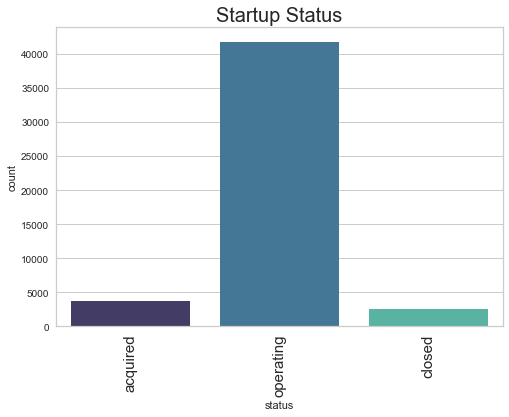

In [3]:
Status_count = sns.countplot(x="status", data=startup , palette="mako")
Status_count.tick_params(axis='x', rotation=90 , labelsize=15)
Status_count.set_title('Startup Status' , fontsize=20)

### the period between the founding year and first funding

In [ ]:
startup['first_funding_year'] = startup['first_funding_at'].apply(lambda x: x.year)
startup['last_funding_year'] = startup['last_funding_at'].apply(lambda x: x.year)
startup = startup[pd.notnull(startup['first_funding_year'])]
startup = startup[pd.notnull(startup['last_funding_year'])]
startup['difference'] = startup['first_funding_year'] - startup['founded_year'] 

count_1_3years = ((1 < startup['difference']) & (startup['difference'] <= 3)).sum()
count_3_7years = ((3 < startup['difference']) & (startup['difference'] <= 7)).sum()
count_8_15years = ((8 <= startup['difference']) & (startup['difference'] <= 15)).sum()
count_15years = ( (startup['difference'] > 15)).sum()

Count_difference_years = [ ['1 to 3 years',count_1_3years] , ['4 to 7 years' , count_3_7years] , ['8 to 15 years' , count_8_15years] , ['more than 15 years' , count_15years] ]
Count_difference_years = pd.DataFrame(Count_difference_years, columns = ['Range','Difference'])

sns.set(rc = {'figure.figsize':(13,6)})
count_barplot =sns.barplot(x="Range", y="Difference", data=Count_difference_years , palette="mako" )
count_barplot.set_title('the period between the founding year and first funding')

 ---------------------------------------------------------------------------------------------------------------------------

ReOrdering the columns 

In [ ]:
startup = startup[['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'country_code', 'state_code', 'region', 'city',
       'funding_rounds', 'founded_at', 'founded_month', 'founded_quarter',
       'founded_year', 'first_funding_at', 'last_funding_at', 'seed',
       'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note',
       'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity',
       'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A',
       'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G',
       'round_H', 'first_funding_year', 'last_funding_year',
       'difference' , 'status']]

# 3- Dealing with imbalanced classes

### Dropping irrelveant columns 

In [ ]:
## permalink and homepage_url irrelveant columns 
## market can replace category list column
#drop founded month , year , quarter since founded_at column contains the whole data
## drop the state_code , region , city as keep only the country code 
startup.drop(['permalink', 'homepage_url' , 'category_list' , 'founded_month','founded_quarter','founded_at' , 'state_code' , 'region' , 'city'
             , 'last_funding_at' , 'first_funding_at'],
             axis='columns',inplace=True) 

In [ ]:
#checking null values to esnure that proper handling was done 
startup.isnull().sum(axis = 0)

### Encoding all columns
for better classifcation
LabelEncoder was used instead of one hot encoding due to the high number of unique values.
if one hot encoding was used it will result in a high number of features 

In [ ]:
#encoding all categorical columns
for column in startup[['name' , 'market' , 'country_code'  ]]:
 startup[column] = LabelEncoder().fit_transform(startup[column])


In [ ]:
#encoding the target feature and checking the labels for each class 
le = LabelEncoder()
startup['status']=le.fit_transform(startup['status'])

#checks the labels mapping
labels_dict = {index: value for index, value in enumerate(le.classes_)}
print(labels_dict)



### Split the data

In [ ]:
# split y and x 
startup_data = startup.values
X, y = startup_data[:, :-1], startup_data[:, -1]
y=y.astype('int')

In [ ]:
## Count of each class rows 
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

### Use Synthetic Minority Oversampling Technique to handle the imbalanced data

In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

As it can be seen from the plot the classes are equaly distributed 

In [ ]:
## Count of each class rows 
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

# 4- Classification 

## Random Forest

In [ ]:
#Split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)


#fitting the model 
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


### using k-fold to evaluate the model

In [ ]:

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))



### Confusion matrix 

In [ ]:
#plot the confusion matrix 
plot_confusion_matrix(rf, X_test, y_test , cmap = 'Blues') 

### Evaluate the model Using the test data

In [ ]:
#evaluate the testing data
prediction = rf.predict(X_test)
print ('Accuracy:', accuracy_score(y_test, prediction))

### Identify the important features 

In [ ]:
#Find the important features 
startup_col = startup.drop(columns=['status'])
feature_names = [i for i in startup.columns if startup[i].dtype in [np.int64]]
perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = startup_col.keys().tolist())

### Precision , Recall and F1 for each class

In [ ]:

classes = [0,1,2]
visualizer = ClassificationReport(rf, classes=classes, support=True)
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

In [ ]:
 from sklearn.metrics import classification_report
print(classification_report(y_test,prediction)) 

## Tuning the model

In [ ]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

model_params = {
    'n_estimators': [500, 1000],
    'max_features': ['sqrt', 0.25, 0.5],
    'max_depth': [25]
}

rf_model = RandomForestClassifier(random_state=1)
clf = GridSearchCV(rf_model, model_params, cv=5)
model = clf.fit(scaled_X_train, y_train)

from pprint import pprint
pprint(model.best_estimator_.get_params())
